# Рынок заведений общественного питания Москвы

Анализ ситуации на рынке общественного питания Москвы.
На основе открытых данных, требуется определить перспективный вид заведения, его численность и район расположения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1">Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2">Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Cоотношение-видов-объектов-общественного-питания-по-количеству." data-toc-modified-id="Cоотношение-видов-объектов-общественного-питания-по-количеству.-2.1">Cоотношение видов объектов общественного питания по количеству.</a></span></li><li><span><a href="#Отношение-сетевыx-к-несетевым" data-toc-modified-id="Отношение-сетевыx-к-несетевым-2.2">Отношение сетевыx к несетевым</a></span></li><li><span><a href="#Количество-мест-в-сетевых-заведениях" data-toc-modified-id="Количество-мест-в-сетевых-заведениях-2.3">Количество мест в сетевых заведениях</a></span></li><li><span><a href="#Среднее-количество-посадочных-мест." data-toc-modified-id="Среднее-количество-посадочных-мест.-2.4">Среднее количество посадочных мест.</a></span></li><li><span><a href="#География-объектов" data-toc-modified-id="География-объектов-2.5">География объектов</a></span><ul class="toc-item"><li><span><a href="#Топ-10-улиц-по-количеству-объектов-общественного-питания." data-toc-modified-id="Топ-10-улиц-по-количеству-объектов-общественного-питания.-2.5.1">Топ-10 улиц по количеству объектов общественного питания.</a></span></li></ul></li><li><span><a href="#Улицы-с-одним-объектом-общественного-питания" data-toc-modified-id="Улицы-с-одним-объектом-общественного-питания-2.6">Улицы с одним объектом общественного питания</a></span></li><li><span><a href="#Количество-посадочных-мест-на-улицах-с-большим-количеством-объектов-общественного-питания." data-toc-modified-id="Количество-посадочных-мест-на-улицах-с-большим-количеством-объектов-общественного-питания.-2.7">Количество посадочных мест на улицах с большим количеством объектов общественного питания.</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3">Вывод</a></span></li></ul></div>

## Загрузка и подготовка данных

In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", 150)
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests
import json 
import re
from nltk.metrics import edit_distance
from matplotlib.patches import Patch

In [2]:
try:
    df = pd.read_csv('/datasets/rest_data.csv')
except:
    df = pd.read_csv('datasets/rest_data.csv')

In [3]:
df.sample(5)

,id,object_name,chain,object_type,address,number
3741,28041,Столовая ВЭИ им.Ленина,нет,столовая,"город Москва, Красноказарменная улица, дом 12, строение 1",120
2314,25292,Шоколадница,да,кафе,"город Москва, Измайловское шоссе, дом 71, корпус А",65
9566,165827,ЛАПША,нет,кафе,"город Москва, улица Барклая, дом 12",21
14426,220421,Арт-Галерея,нет,ресторан,"город Москва, 3-я улица Ямского Поля, дом 2, корпус 4",24
1224,126452,Шоколадница,да,кафе,"город Москва, Фестивальная улица, дом 13, корпус 1",70


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


У нас есть данные о 15 тысячах московских заведений. По каждому изветстны название, тип, адрес, количество мест и является ли объект сетевым.

In [5]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [6]:
# укоротим наименования видов для удобства вывода данных
df.loc[df['object_type'] == 'магазин (отдел кулинарии)', 'object_type'] = 'магазин'
df.loc[df['object_type'] == 'предприятие быстрого обслуживания', 'object_type'] = 'фастфуд'

In [7]:
df.query('chain == "да"').groupby('object_name')['object_name'].count()

object_name
Beverly Hills Diner    1
Bierloga               1
Black & White          1
Bocconcino             3
BooBo                  1
                      ..
кафе «Папа Джонс»      1
кафе «Старбакс»        2
кафе «Шоколадница»     1
ресторан «Брудер»      1
ресторан «Якитория»    1
Name: object_name, Length: 724, dtype: int64

В сетевых названиях встречаются разночтения. Будет удобно, если  все сетевые заведения будут называться одинаково. Проверим так же все ли они обозначены как сетевые.

In [8]:
# список сетевых заведений для последующей унификации их названий ипроверки колонки 'chain'
chain_list = [
    'Якитория',
    'Старбакс',
    'ДоДо ',
    'Макдоналдс',
    'Шоколадница',
    'Subway',
    'Джонс',
    'KFC',
    'Pizza Hut',
    'Азбука Вкуса'    
]

In [9]:
def cafe_rename(cafe_name):
    for i in chain_list:
        if i.lower() in cafe_name.lower():
            return i
    return cafe_name

In [10]:
df['object_name'] = df['object_name'].apply(cafe_rename)

In [11]:
# обозначаем крупные сети принудительно, как сетевые
def chain_rename(row):
    for i in chain_list:
        if i == row['object_name']:
            return 'да'
    return row['chain']

In [12]:
df['chain'] = df.apply(chain_rename, axis=1)

Среди видов заведений есть 'предприятие быстрого обслуживания', который мы для краткости переименовали в фастфуд. Некоторые заведения представители крупных сетей являющиеся фастфудами в таблице обозначены как рестораны и кафе.

In [13]:
fastfood = [
    'ДоДо ',
    'Макдоналдс',
    'Subway',
    'Джонс',
    'KFC'
]

len(df.query('object_name in @fastfood and object_type != "фастфуд"')) #.sample(5)

229

In [14]:
def type_rename(row):
    for i in fastfood:
        if i == row['object_name']:
            return 'фастфуд'
    return row['object_type']

Заменим тип известных сетей быстрого питания на "фастфуд"

In [15]:
df['object_type'] = df.apply(type_rename, axis=1)

In [16]:
df.query('object_name not in @fastfood').sample(5)

,id,object_name,chain,object_type,address,number
8256,133282,Фреш Смуси Бар,нет,кафе,"город Москва, Верхняя Красносельская улица, дом 3А",1
10075,171748,Кафе 5 +,нет,кафе,"город Москва, Семёновская площадь, дом 7, корпус 17",46
11379,189110,"Соки, выпечка",нет,буфет,"город Москва, Пятницкое шоссе, дом 18",0
4655,28873,Школа Интеллект,нет,буфет,"город Москва, Ставропольская улица, дом 16",100
2248,88186,Кафе «Цитадель»,нет,кафе,"город Москва, Большая Грузинская улица, дом 52",58


Проверим данные на дубликаты

In [17]:
len(df[df.duplicated()])

0

Полные дубликаты отсутствуют. Проверим есть ли неявные дубликаты - объекты находящиеся по одному адресу, с одинаковым названием и одинаковым количеством посадочных мест. 

In [18]:
# df[df[['address', 'object_name', 'number']].duplicated(keep=False)].sort_values(by='address')
df[df[['address', 'object_name', 'number']].duplicated()].sort_values(by='address')

,id,object_name,chain,object_type,address,number
5188,107466,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5190,107480,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5186,107574,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",10
5185,107442,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",20
2378,28607,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,закусочная,"город Москва, 2-я Бауманская улица, дом 5, строение 1",16
...,...,...,...,...,...,...
12744,183901,Гацоева Анжела Камалдиновна,нет,фастфуд,"город Москва, улица Сущёвский Вал, дом 5, строение 5",2
11066,183855,Каменев Василий Владимирович,нет,кафе,"город Москва, улица Сущёвский Вал, дом 5, строение 6",1
14223,205506,Кафе,нет,кафе,"город Москва, улица Трофимова, владение 36",40
6423,19759,БАР,нет,бар,"город Москва, улица Улофа Пальме, дом 5, строение 1",10


87 записи дублируют имеющиеся и отличаются только идентификатором `id`. Их можно сразу удалить.

In [19]:
df = df.drop(df[df[['address', 'object_name', 'number']].duplicated()].index)
len(df[df[['address', 'object_name', 'number']].duplicated()]) # проверка


0

Посмотрим на записи имеющие одинаковый адрес и одинаковую характеристику количество посадочных мест. Очень вероятно что совпадение этих параметров выявит дубликаты с опечатками в названии.

In [20]:
print('Количество потенциальных пар дубликатов: ', len(df[df[['address', 'number']].duplicated(keep=False)]))
df[df[['address', 'number']].duplicated(keep=False)].sort_values(by='address').head(10)

Количество потенциальных пар дубликатов:  2452


,id,object_name,chain,object_type,address,number
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100
860,23604,Буфет - ГБОУ 60,нет,буфет,"Партизанская улица, дом 30",100
13991,204917,Шаурма на углях- Чайхана Баракат,нет,кафе,"Таганская площадь, дом 88, строение 4",80
8808,24987,Шаурма на углях-Чайхана баракат,нет,кафе,"Таганская площадь, дом 88, строение 4",80
9304,166996,Банкетный зал «Кристалл BallRoom»,нет,кафе,"город Москва, 1-й Красногвардейский проезд, дом 21, строение 2",100
9333,167306,Ресторан «Insight»,нет,ресторан,"город Москва, 1-й Красногвардейский проезд, дом 21, строение 2",100
12304,200600,Coffee Moose,нет,фастфуд,"город Москва, 1-я Владимирская улица, дом 37/15",0
367,142615,"Шаурма, куры-гриль",нет,фастфуд,"город Москва, 1-я Владимирская улица, дом 37/15",0
13017,197815,Кофе,нет,ресторан,"город Москва, 1-я Квесисская улица, дом 18",0
13019,198545,Донер,нет,закусочная,"город Москва, 1-я Квесисская улица, дом 18",0


На примере первых четырех строк видно, дубликаты имеющие отличия в наименовании в несколько символов (опечаток) действительно есть. Для поиска таких дубликатов среди 2452 претендентов подошел бы метод на основе расстояния Левенштейна. Но в категорию дубликатов попадут заведения имеющие в имени порядковый номер, например буфеты в МГУ. В то же время если количество отличий очень велико (например в одном случае аббревиатура в другом расшифровка) то такой дубликат не будет выявлен. Примем наличие этих дубликатов и прочих ошибок в данных, как неизбежный факт не оказывающий значительного влияния на результат исследования.

Итак, в данных много неточностей. В написании названий сетей, в определении типов заведений. Есть аномально большие значения количества посадочных мест. Крупные и знакомые нам сети мы переименовали однотипно и обозначили их как сетевые. С количествами посадочных мест пока не будем ничего предпринимать.

В данных присутствуют неявные дубликаты идентичные записи но сразными идентификаторами, и объекты записанные дважды но с отличиями в наименовании. Причина появления дубликатов находится в открытом источнике данных, скорее всего эти заведения записаны там дважды. Вохможно из-за несвоевременного обновления данных при внесении изменений.
Или объекты записаны в нескольких исходных источниках (если источников несколько) и при объединении они не были идентифицированы как дубликаты. 

## Анализ данных

### Cоотношение видов объектов общественного питания по количеству.

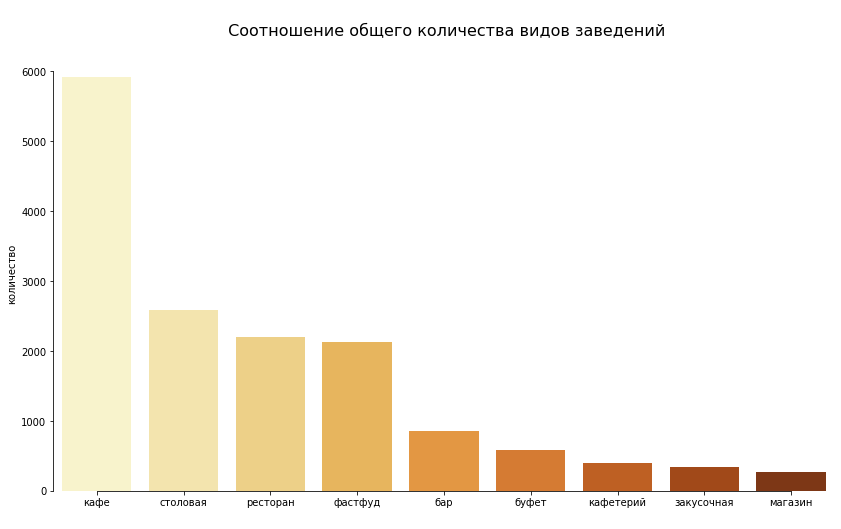

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))
order = df.groupby('object_type').count().sort_values(by='id', ascending=False).index
ax = sns.countplot(x="object_type", data=df, order = order, palette="YlOrBr")
ax.set_title('\n Соотношение общего количества видов заведений', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
sns.despine(trim=True);

In [22]:
len(df.query('object_type == "кафе"')) / len(df)

0.3877217095359644

38 % от общего количества заведений составляют кафе. Правда под кафе может скрываться и бар и небольшой ресторан и шаверма.

### Отношение сетевыx к несетевым


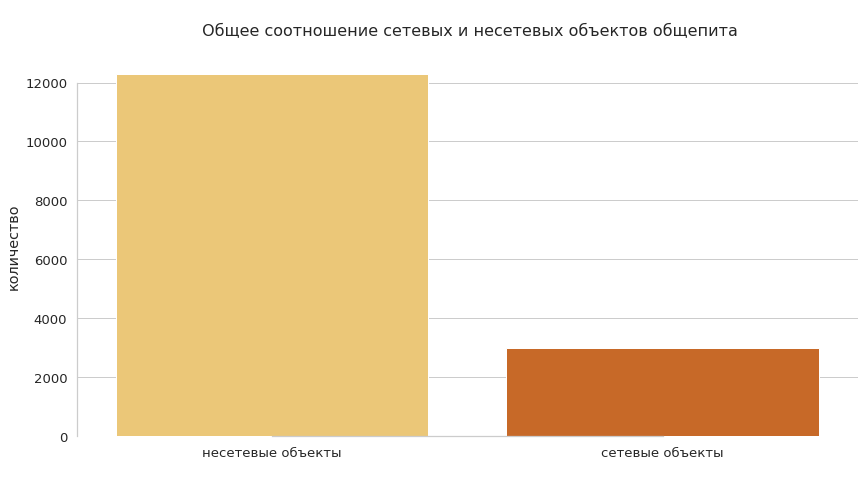

In [23]:
sns.set(font_scale = 1.2, style="whitegrid")
sns.set_palette("YlOrBr")
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.countplot(x="chain", data=df,palette="YlOrBr", dodge= True)
ax.set_title('\n Общее соотношение сетевых и несетевых объектов общепита', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
ax.set_xticklabels(['несетевые объекты', 'сетевые объекты'])
sns.despine(trim=True);

Посмотрим на сотношение сетевых к несетевым по видам.

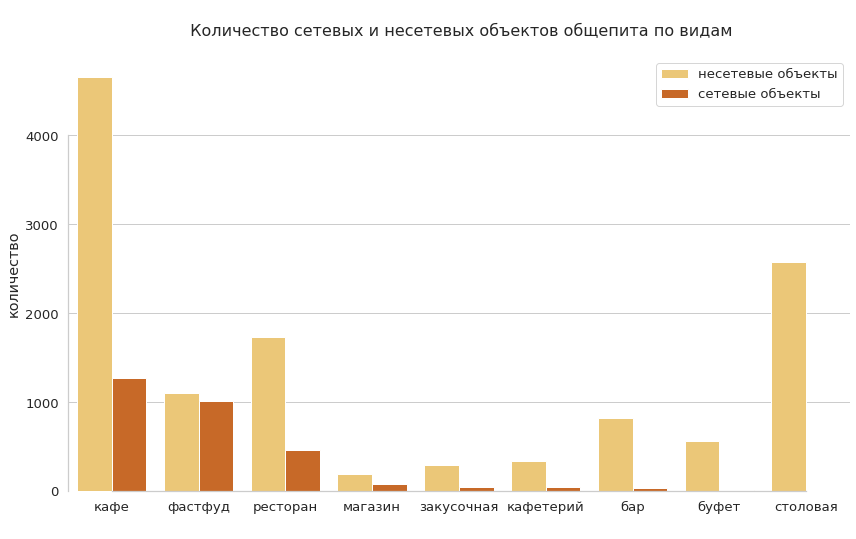

In [24]:
order = df.query('chain == "да"').groupby('object_type').count().sort_values(by='id', ascending=False).index
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.countplot(x="object_type", data=df, order = order, palette="YlOrBr", hue='chain', dodge= True)
ax.set_title('\n Количество сетевых и несетевых объектов общепита по видам', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
ax.legend(['несетевые объекты','сетевые объекты']);
sns.despine(trim=True);

Сетевое распространение характерно для кафе и фастфудов. Чуть в меньшей степени для ресторанов. Построение сети на основе прочих видов встречается очень редко.

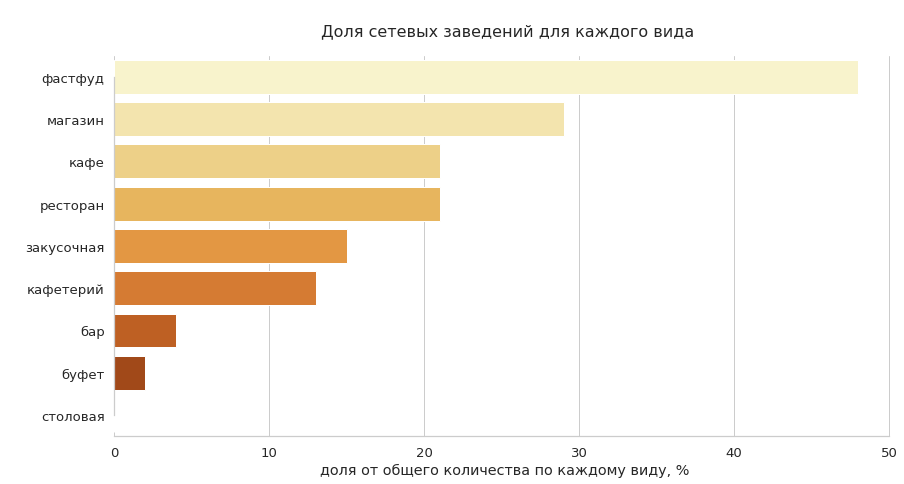

In [25]:
to_plot = df.groupby(['object_type', 'chain'])['id'].count().unstack().reset_index()
to_plot.columns = ['object_type', 'yes', 'no']
to_plot['chain_prcnt'] = (to_plot['yes'] / (to_plot['yes'] + to_plot['no'])*100).round()
to_plot['not_chain_prcnt'] = (to_plot['no'] / (to_plot['yes'] + to_plot['no'])*100).round()
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.barplot(y="object_type", x='chain_prcnt', data=to_plot.sort_values(by='chain_prcnt', ascending=False), 
                 palette="YlOrBr")
ax.set_title('\n Доля сетевых заведений для каждого вида', fontsize=16, pad=20)
ax.set(xlabel='доля от общего количества по каждому виду, %', ylabel=' ')

sns.despine(trim=True);

Среди фастфудов относительно общего количества сетевых объектов почти половина. (Правда, нужно помнить что представители крупных сетей 'Макдоналдс','Subway','KFC' и т.п изначально были обозначены не обязательно, как сетевые и являющиеся фастфудами.) 

### Количество мест в сетевых заведениях

Построим диаграмму, что бы определить какое количество заведений и количество мест в них характерно для сетей.

In [26]:
chain_objects_pivot = df.query('chain == "да"').groupby('object_name').agg({'id': 'count', 'number': 'mean'})


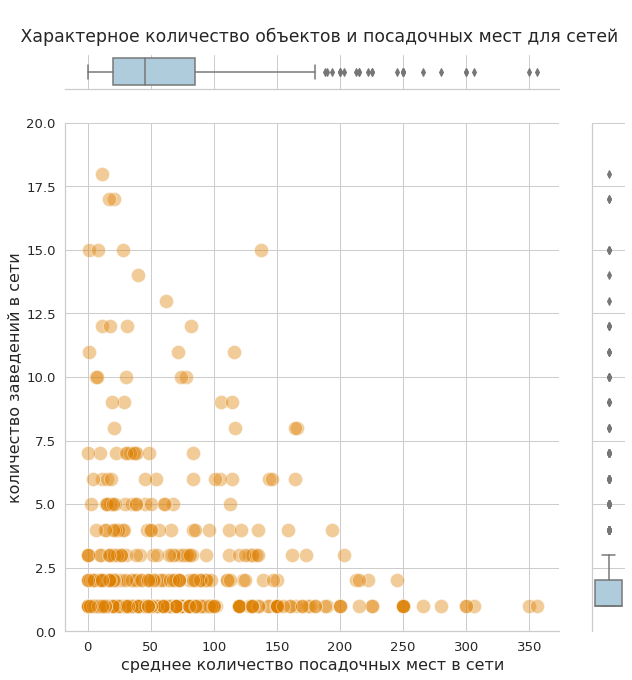

In [27]:
# функция против ошибки "TypeError: boxplot() got an unexpected keyword argument 'vertical'"
def marginal_boxplot(a, vertical=False, **kws):
    if vertical:
        sns.boxplot(y=a, **kws)
    else:
        sns.boxplot(x=a, **kws)
               
ax = sns.JointGrid(data=chain_objects_pivot, x="number", y="id", ylim=(0, 20), height=9, ratio=8, space=1)

ax.plot_joint(sns.scatterplot, s=200, linewidth=1, color='#DD8002', alpha=0.4)
ax.plot_marginals(marginal_boxplot, palette='Paired')

ax.set_axis_labels('среднее количество посадочных мест в сети', 'количество заведений в сети', fontsize=16)
ax.fig.suptitle("\n Характерное количество объектов и посадочных мест для сетей", y=1.05);

Для сетевых заведений характерно один-два объекта в среднем на 45 посадочных мест. Странно, что в данных присутствуют сети в которых всего одно заведение. Возможно заведения этих сетей по разному называются или в москве собраны еденичные представители сетей из других городов.

### Среднее количество посадочных мест.

Посмотрим на распределение количества посадочных мест по типам.

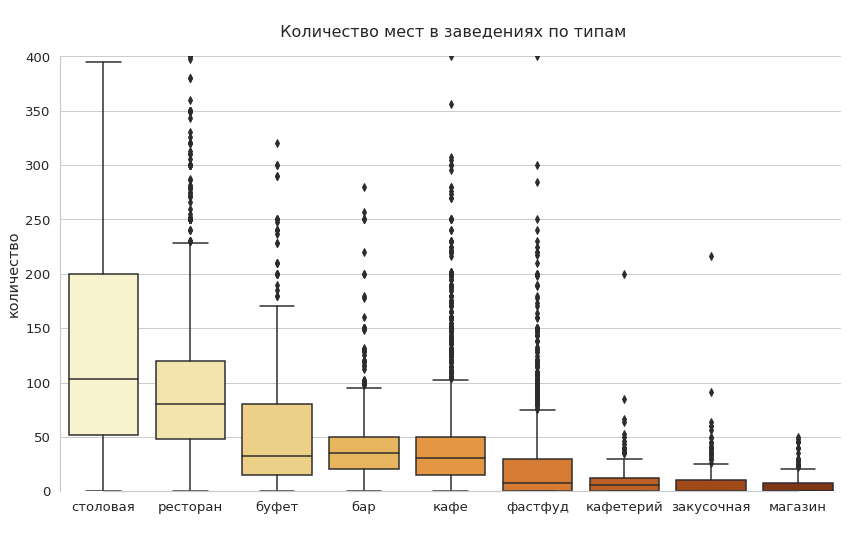

In [28]:
order = df.groupby('object_type')['number'].mean().sort_values( ascending=False).index
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.boxplot(x="object_type", y="number", data=df, order=order, palette="YlOrBr")
ax.set(ylim=(0, 400))
ax.set_title('\n Количество мест в заведениях по типам', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
sns.despine(trim=True);

Для всех типов характерно наличие значительных выбросов. Нельзя однозначно сказать это ошибки в данных или такие заведения действительно есть. Скорее всего количество за 500 для баров и ресторанов это ошибки. А столовая крупного учреждения может быть такой вместительности если это несколько залов на территории объединенных одним юридическим лицом. 

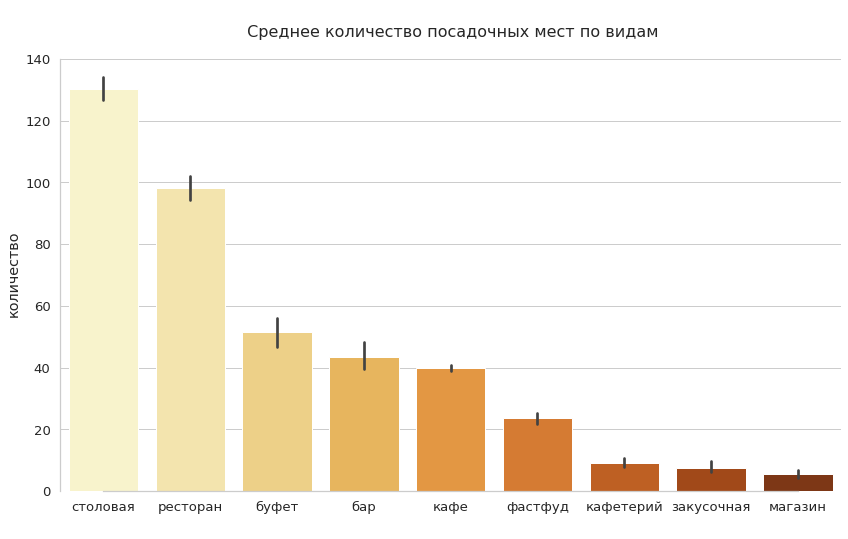

In [29]:
order = df.groupby('object_type')['number'].mean().sort_values( ascending=False).index
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.barplot(x='object_type', y='number', data=df, order=order, palette="YlOrBr")
ax.set_title('\n Среднее количество посадочных мест по видам', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
sns.despine(trim=True);

Максимальное количество посадочных мест в столовых, особо вместительные столовые вероятно заведения предприятий у учреждений. 
Следующие по вместительности рестораны в среднем на 100 посетителей.

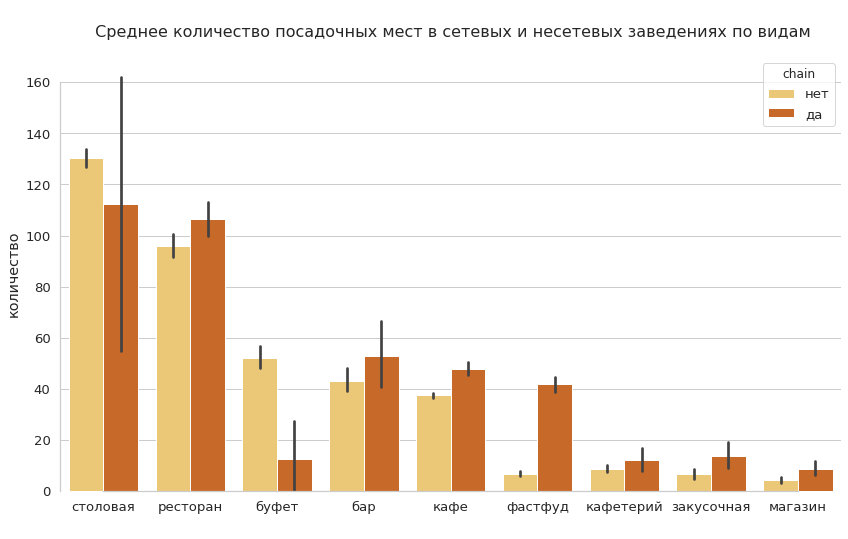

In [30]:
order = df.groupby('object_type')['number'].mean().sort_values( ascending=False).index
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.barplot(x='object_type', y='number', data=df, 
                 order=order, 
                 palette="YlOrBr", 
                 hue='chain')
ax.set_title('\n Среднее количество посадочных мест в сетевых и несетевых заведениях по видам', fontsize=16, pad=20)
ax.set(ylabel='количество', xlabel=' ')
sns.despine(trim=True);

Кафеттерии, закусочные, точки питания в магазинах, а так же несетевые фастфуды имеют самую низкую среднюю вместимость около 10 посадочных мест. 
А вот сетевые фастфуды не уступают по средней вместимости кафе и барам. Если встанет задача уточнять классификацию, то фастфуды можно разделить на два вида. Макдональдсы и Сабвэи отделить от маленьких шаверм.

In [31]:
df.query('object_type == "буфет" and chain == "да"')

,id,object_name,chain,object_type,address,number
1054,138535,Кофе с собой,да,буфет,"город Москва, Большая Серпуховская улица, дом 31, корпус 10",0
2046,138842,Кофе с собой,да,буфет,"город Москва, Новокузнецкая улица, дом 39",0
6089,23888,ТЕРЕМОК,да,буфет,"город Москва, улица Миклухо-Маклая, дом 32А",20
7006,157300,Азбука Вкуса,да,буфет,"город Москва, проезд Аэропорта, дом 8",0
9970,171198,Хлеб насущный,да,буфет,"город Москва, Климентовский переулок, дом 9/1",50
11968,181328,Крошка картошка,да,буфет,"город Москва, Боровское шоссе, дом 6",0
12956,200711,Милти,да,буфет,"город Москва, Профсоюзная улица, дом 118",0
15089,215716,Суп Кафе,да,буфет,"город Москва, Скаковая улица, дом 17, строение 2",70
15176,217037,Кофе с собой,да,буфет,"город Москва, Ярцевская улица, дом 25А",0
15203,216666,Теремок,да,буфет,"город Москва, Солнцевский проспект, дом 21",0


А вот обратный эффект с буфетами можно списать на неточность данных.  8 сетевых буфетов с нулевым количеством посадочных мест слишком маленькая выборка, что бы делать выводы.

### География объектов

Выделим в отдельный столбец информацию об улице из столбца address.

In [32]:
street_types = [
    'улица', 'переулок', 'проспект', 'площадь', 'шоссе', 'набережная', 'тупик',
    'проезд', 'бульвар', 'аллея', 'просек', 'квартал',
#     'километр', 
]


def get_street(list):
    result = 'нет данных'
    sep_list = list.split(sep=', ')
    for i in street_types:
        for k in sep_list:
            if i in k:
                result = k
    return result

In [33]:
df['street'] = df['address'].apply(get_street)
df.sample(3)

,id,object_name,chain,object_type,address,number,street
12172,191865,Нейборс,нет,кафе,"город Москва, Лазоревый проезд, дом 1А, корпус 1",15,Лазоревый проезд
928,83022,SushiSale,нет,фастфуд,"город Москва, улица Преображенский Вал, дом 14",4,улица Преображенский Вал
7941,154372,Кафе «Хлеб насущный»,нет,кафе,"город Москва, Большая Никитская улица, дом 16",45,Большая Никитская улица


#### Топ-10 улиц по количеству объектов общественного питания. 

In [34]:
streets = df.query('street != "нет данных"').groupby('street').agg({
    'id':'count'}).sort_values(by='id', ascending=False).reset_index()
streets.columns = ['street', 'cnt']
top_streets = streets.head(30).copy()
top_streets.head(10)

,street,cnt
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


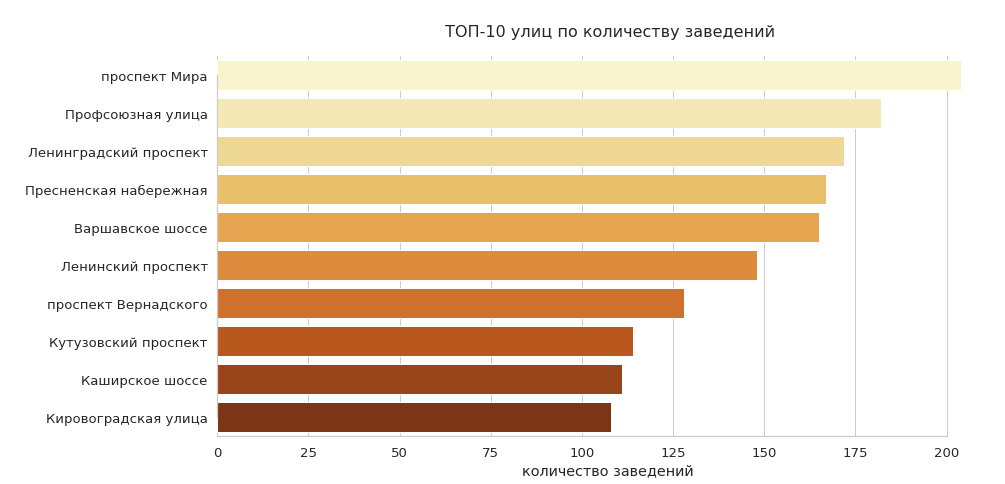

In [35]:
fig, ax = plt.subplots(figsize=(14, 7))
# order = df.groupby('object_type').count().sort_values(by='id', ascending=False).index
ax = sns.barplot(y="street", x='cnt', data=top_streets.head(10), palette="YlOrBr")
ax.set_title('\n ТОП-10 улиц по количеству заведений', fontsize=16, pad=20)
ax.set(xlabel='количество заведений', ylabel=' ')
sns.despine(trim=True);

Посмотрим в каких районах находятся эти улицы. Районы определим с помощью геокодера Яндекс по API.

In [36]:
# принимает наименование улицы, запрашивает по API координаты и возвращает их
def get_coords(street_name):
    url = "https://geocode-maps.yandex.ru/1.x"
    params = {
        "geocode": "Москва, " + street_name,
        "apikey": "6d96e1bf-ea8f-47f8-b77b-cfff232ea793",
        "format": "json"
    }
    response = requests.get(url, params=params)
    response_parsed = json.loads(response.text)
    coords = response_parsed['response']['GeoObjectCollection'][
        'featureMember'][0]['GeoObject']['Point']['pos']
    return coords

In [37]:
# top_streets['coords'] = top_streets['street'].apply(get_coords)
# top_streets

In [38]:
# запрашивает адрес по принятым координатам и возвращает название района
def get_district(coords):
    url = "https://geocode-maps.yandex.ru/1.x"
    params_return = {
        "geocode": coords,
        "apikey": "6d96e1bf-ea8f-47f8-b77b-cfff232ea793",
        "format": "json"
    }
    response_return = requests.get(url, params=params_return)
    response_return_parsed = json.loads(response_return.text)
    district = response_return_parsed['response']['GeoObjectCollection']['featureMember'][1][
    'GeoObject']['metaDataProperty']['GeocoderMetaData']['text'].split(', ')[3]
    return district

In [39]:
# закомментированное применение функции
# top_streets['district'] = top_streets['coords'].apply(get_district)
# top_streets

In [40]:
# результат сохраним в файл на случай если ключ вдруг перестанет работать и что бы не тратить время на выгрузку
# top_streets.to_csv('top_streets.csv')

In [41]:
# импорт результата из внешнего файла
# https://docs.google.com/spreadsheets/d/12-3OgN87hcbExOTqJV-MflD6aljzWrXmqkNInPPsh24/edit?usp=sharing
    
from io import BytesIO
# import requests 
spreadsheet_id = '12-3OgN87hcbExOTqJV-MflD6aljzWrXmqkNInPPsh24'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
top_streets_ex = pd.read_csv(BytesIO(r.content))

top_streets_ex.drop('Unnamed: 0', axis=1)
    

,street,cnt,coords,district
0,проспект Мира,204,37.637937 55.812368,Алексеевский район
1,Профсоюзная улица,183,37.532511 55.649525,район Коньково
2,Ленинградский проспект,173,37.545626 55.794285,Хорошёвский район
3,Пресненская набережная,167,37.540982 55.746791,Пресненский район
4,Варшавское шоссе,162,37.603954 55.599799,район Чертаново Южное
5,Ленинский проспект,148,37.537137 55.68263,Ломоносовский район
6,проспект Вернадского,132,37.515335 55.681656,Ломоносовский район
7,Кутузовский проспект,114,37.50911 55.735013,район Дорогомилово
8,Каширское шоссе,112,37.683194 55.641244,район Москворечье-Сабурово
9,Кировоградская улица,110,37.605023 55.614455,район Чертаново Центральное


Некоторые улицы проходят через несколько районов. Возможно они попали в список топ 10, только потому что они очень длинные. 

In [42]:
# вытаскиваем из адреса информацию о доме
df['house'] = df.query('street != "нет данных"').apply(
    lambda row: row['address'].split(sep=', ')[1 + row['address'].split(
        sep=', ').index(row['street'])],
    axis=1)

Сгрупируем все адреса (улица-дом) и посмотрим есть ли дома с большим количеством заведений.

In [43]:
address_list = df.groupby(['street', 'house']).agg({'id': 'count'}).reset_index()
address_list.sort_values(by='id', ascending=False)

,street,house,id
5017,Ходынский бульвар,дом 4,95
3870,Пресненская набережная,дом 2,66
5702,проспект Мира,дом 211,62
2545,Ленинградское шоссе,дом 16А,55
6692,улица Ленинская Слобода,дом 26,55
...,...,...,...
3007,Михалковская улица,дом 38,1
3006,Михалковская улица,дом 3,1
3005,Михалковская улица,дом 24,1
3004,Михалковская улица,дом 15А,1


Есть адреса по которым находится до полсотни объектов общепита - это торговые центры с фудкортами, вокзалы и крупные деловые комплексы.

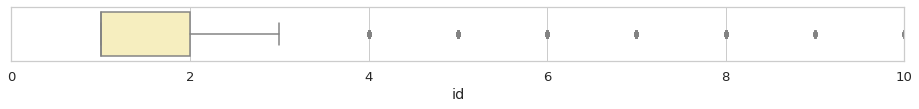

In [44]:
fig, ax = plt.subplots(figsize=(16, 1))
ax = sns.boxplot( x="id", data=address_list)
ax.set(xlim=(0, 10));

In [45]:
1 - len(address_list.query('id > 2'))/len(address_list)

0.8574009549619306

По 85 % адресов находится не более двух заведений в одном доме.


Отсортиртируем улицы в порядке количества на них домов с хотябы одним заведением. Так мы сгладим искажения которые вносят торговые центры.

In [46]:
address_list.groupby('street', as_index=False).agg({'house': 'count'}).sort_values(by='house', ascending=False).head(10)

,street,house
399,Варшавское шоссе,73
689,Ленинский проспект,72
1424,проспект Мира,71
686,Ленинградский проспект,55
1013,Профсоюзная улица,55
599,Каширское шоссе,51
494,Дмитровское шоссе,46
1420,проспект Вернадского,41
240,Алтуфьевское шоссе,40
1025,Пятницкая улица,35


В лидерах по количеству домов с хотябы одним заведением - просто длинные улицы. Сравнивать их с короткими бессмысленно. Нужно либо "разрезать" их на отрезки например по районам, либо сразу смотреть на количество заведений в разных районах. В любом случае нам требуется получить информацию о районах города для каждого заведения.

В идеале было бы с помощью геокодинга выгрузить район для каждого заведения, или хотя бы для каждого адреса, а потом группировать по районам.  Но геокодинг Яндекса ограничивает некоммерческое использование 1000 запросамив сутки, запросы обрабатываются не быстро а в случае превышения лимита блокируется ключ API. Обработка 7000 запросов будет очень неудобной. По этому попробуем найти какой нибудь справочник улиц-районов в интернете. 

Вот например база жилых домов Москвы.

In [47]:
try:
    buildings_moscow = pd.read_csv('moscow-buildings.csv')
except:
    spreadsheet_id = '16jzb6wukIEKsZ3EomGPwL31SFiNAfer-SQd0NbspKEE'
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    buildings_moscow = pd.read_csv(BytesIO(r.content))

buildings_moscow.sample(5)

,area_id,full_address,city,address,street_prefix,street_name,building,house_id,area_name,house_year
13111,2281059,г Москва пер Брюсов д.1 б,Москва,пер Брюсов д.1 б,пер,Брюсов,д.1 б,8121226,муниципальный округ Якиманка,н.д.
12397,2281057,г Москва ул Тверская д.29 строение 2,Москва,ул Тверская д.29 строение 2,ул,Тверская,д.29 строение 2,7742611,муниципальный округ Тверской,1917
4960,2281079,г Москва ул Старокачаловская д.6,Москва,ул Старокачаловская д.6,ул,Старокачаловская,д.6,7835148,муниципальный округ Северное Бутово,1997
15006,2281047,г Москва ул Расплетина д.12 кор.2,Москва,ул Расплетина д.12 кор.2,ул,Расплетина,д.12 кор.2,7955156,муниципальный округ Щукино,н.д.
17492,2281034,г Москва ул Санникова д.9 кор.2,Москва,ул Санникова д.9 кор.2,ул,Санникова,д.9 кор.2,8148450,муниципальный округ Отрадное,1986


Здесь есть интересующие нас названия улиц, номера домов, и самое главное район города.
Произведем необходимую подготовку.

In [48]:
#уберем лишние пробелы в наименовании улиц
buildings_moscow['street_name'] = buildings_moscow['street_name'].str.strip()
# приведем номер дома к одной цифре
buildings_moscow['building'] = buildings_moscow['building'].str.replace('д.', '')
# buildings_moscow['building'] = buildings_moscow['building'].str.replace('( строение.)\d*', '')
# buildings_moscow['building'] = buildings_moscow['building'].str.replace('( кор.)\d*', '') 
buildings_moscow['building'] = buildings_moscow['building'].str.replace('\D+\d*', '') # так надежнее 
# оставим от наименования района одно название
buildings_moscow['area_name'] = buildings_moscow['area_name'].str.replace('муниципальный округ ', '') 
buildings_moscow['area_name'] = buildings_moscow['area_name'].str.strip()
# удалим дубликаты возникшие после ликвидации "суффиксов"
buildings_moscow = buildings_moscow.drop_duplicates(subset=('street_name', 'building'))

In [49]:
# изменим тип данных номера дома
buildings_moscow['building'] = pd.to_numeric(buildings_moscow['building'], errors='coerce', downcast='signed')#.round()
buildings_moscow.sample(5)

,area_id,full_address,city,address,street_prefix,street_name,building,house_id,area_name,house_year
7311,2281064,г Москва пр-кт 40 лет Октября д.18/13,Москва,пр-кт 40 лет Октября д.18/13,пр-кт,40 лет Октября,18.0,7566367,Люблино,1969
646,2281087,г Москва ул Рощинская 3-я д.12/18,Москва,ул Рощинская 3-я д.12/18,ул,Рощинская 3-я,12.0,7876195,Даниловский,1973
3425,2281073,г Москва ул Вавилова д.14,Москва,ул Вавилова д.14,ул,Вавилова,14.0,7665141,Гагаринский,1960
13034,2281059,г Москва пр-кт Ленинский д.3,Москва,пр-кт Ленинский д.3,пр-кт,Ленинский,3.0,8071717,Якиманка,1966
19217,2281010,г Москва ул Селигерская д.18 кор.1,Москва,ул Селигерская д.18 кор.1,ул,Селигерская,18.0,7929514,Бескудниковский,2010


In [50]:
# удаляем пустые значения в префиксе улиц
buildings_moscow = buildings_moscow[~buildings_moscow['street_prefix'].isna()].copy()

# приведем префикс улиц к полному виду с помощью словаря
street_prefix_dict = {
    'ул': 'улица',
    'пер': 'переулок',
    'пр-кт': 'проспект',
    'пл': 'площадь',
    'ш': 'шоссе',
    'наб': 'набережная',
    'туп': 'тупик',
    'проезд': 'проезд',
    'б-р': 'бульвар',
    'аллея': 'аллея',
    'просек': 'просек',
    'кв-л': 'квартал',
    'линия':'линия',
    'п': 'поселок',
    'мкр': 'микрорайон',
    'пгт': 'пгт',
    'д.3': 'д.3'
}
buildings_moscow['street_prefix'] = buildings_moscow['street_prefix'].apply(lambda x: street_prefix_dict[x])

In [51]:
buildings_moscow[['street_prefix', 'street_name', 'building', 'area_name']].sample(5)

,street_prefix,street_name,building,area_name
6741,проспект,Волгоградский,78.0,Кузьминки
21298,проезд,Красностуденческий,5.0,Тимирязевский
4343,улица,Нагорная,27.0,Котловка
23501,улица,Гришина,7.0,Можайский
636,улица,Мытная,60.0,Даниловский


Подготовим датасет с ресторанами, создадим поля, что бы произвести соединение таблиц.

In [52]:
# убираем "улица" и т.п. из названий улиц 
def get_street_name(street):
    for i in street_types:
        if i in street:
            return street.replace(i, '').strip()   
        
df['street_name'] = df['street'].apply(get_street_name)

In [53]:
df['building'] = df['house'].str.replace('дом ', '')
df['house'] = df['house'].str.replace('владение ', '')
df['building'] = df['building'].str.replace('\D+\d*', '')
df['building'] = pd.to_numeric(df['building'], errors='coerce', downcast='signed')
df['street_name'] = df['street_name'].str.replace('ё', 'е')

In [54]:
# получим префикс для названий улиц
def get_street_prefix(street):
    for i in street_types:
        if i in street:
            return i   
        
df['street_prefix'] = df['street'].apply(get_street_prefix)
df.sample(3)

,id,object_name,chain,object_type,address,number,street,house,street_name,building,street_prefix
6129,152286,Ресторан«ВьетКафе»,да,ресторан,"город Москва, Симферопольский бульвар, дом 22, корпус 3",55,Симферопольский бульвар,дом 22,Симферопольский,22.0,бульвар
8451,74884,Glenuill,нет,ресторан,"город Москва, Садовая-Самотёчная улица, дом 20, строение 1",55,Садовая-Самотёчная улица,дом 20,Садовая-Самотечная,20.0,улица
4259,124443,Хорошее дело,нет,кафе,"город Москва, Большой Сухаревский переулок, дом 25, строение 1",40,Большой Сухаревский переулок,дом 25,Большой Сухаревский,25.0,переулок


Создадим из базы жилых домов справочник улица-район, но сначала проверим для всех ли улиц будет справедливо такое соответствие. Найдем улицы проходящие через несколько районов.

In [55]:
# можно определить какие улицы в нескольких районах
buildings_moscow.groupby(['street_prefix', 'street_name'])['area_name'].nunique().sort_values(ascending=False).head(5)

street_prefix  street_name  
проспект       Ленинский        8
шоссе          Варшавское       7
улица          Профсоюзная      6
проспект       Ленинградский    5
               Нахимовский      5
Name: area_name, dtype: int64

In [56]:
# посчитаем сколько таких улиц
many_districts_streets = buildings_moscow.groupby(
    'street_name')['area_name'].nunique().reset_index().query('area_name > 1')
many_districts_streets

,street_name,area_name
7,60-летия Октября,2
9,8 марта,2
10,800-летия Москвы,3
37,Академика Волгина,2
43,Академика Королева,2
...,...,...
2033,Щелковское,2
2049,Энтузиастов,4
2057,Юных Ленинцев,2
2079,Яна Райниса,2


215 улиц проходят более чем через 1 район. Что бы определить район объекта на них нужно сверяться с номером дома. Для улиц одного района сделаем справочник "улица-район".

In [57]:
one_district_streets = buildings_moscow.groupby([
    'street_name', 'street_prefix'])['area_name'].nunique().reset_index().query('area_name < 2')
one_district_streets.tail(5)

,street_name,street_prefix,area_name
2118,Ясный,проезд,1
2119,Яузская,аллея,1
2120,Яузская,улица,1
2121,Яузский,бульвар,1
2122,Яхромская,улица,1


In [58]:
one_district_streets = list(one_district_streets['street_name']) 
district_guide = buildings_moscow.query('street_name in @one_district_streets').pivot_table(
    index=('street_name', 'street_prefix', 'area_name')).reset_index()[['street_name', 'street_prefix', 'area_name']]

In [59]:
district_guide.head(5)

,street_name,street_prefix,area_name
0,1 Маевки,аллея,Вешняки
1,10-летия Октября,улица,Хамовники
2,1812 года,улица,Дорогомилово
3,1905 года,улица,Пресненский
4,26-ти Бакинских Комиссаров,улица,Тропарево-Никулино


In [60]:
df = df.merge(district_guide, on=('street_name', 'street_prefix'), how='left')

In [61]:
len(df[~df['area_name'].isna()])

8044

Только для 7709 заведений район можно определить точно по улице. Остальные находятся на улицах проходящих через несколько районов. Ситуация осложняется тем что если граница двух районов проходит по улице, то четные дома по ней оказываются в одном районе а нечетные в другом (например бульвар Яна Райниса четная сторона которого лежит в Северном Тушино, а нечетная в Южном). 

In [62]:
# определяем для каждой улицы максимальный номер дома для района, через который она идет
# четные номера 
even_street_districts = buildings_moscow.query(
#     'street_name not in @one_district_streets and 
    'building % 2 == 0').groupby(
    ['street_name', 'street_prefix', 'area_name'])['building'].max().reset_index().sort_values(by='street_name')
even_street_districts.tail(10)

,street_name,street_prefix,area_name,building
1842,Ярославская,улица,Алексеевский,16.0
1843,Ярославское,шоссе,Ярославский,144.0
1844,Ярцевская,улица,Кунцево,34.0
1845,Ясеневая,улица,Орехово-Борисово Южное,44.0
1846,Яснополянская,улица,Рязанский,6.0
1847,Ясный,проезд,Южное Медведково,34.0
1848,Яузская,аллея,Богородское,4.0
1849,Яузская,улица,Таганский,6.0
1850,Яузский,бульвар,Таганский,14.0
1851,Яхромская,улица,Дмитровский,14.0


In [63]:
# нечетные номера
odd_street_districts = buildings_moscow.query(
#     'street_name not in @one_district_streets and 
    'building % 2 == 1').groupby(
    ['street_name', 'street_prefix', 'area_name'])['building'].max().reset_index()
odd_street_districts.tail(10)

,street_name,street_prefix,area_name,building
1823,Янтарный,проезд,Лосиноостровский,35.0
1824,Ярославская,улица,Алексеевский,21.0
1825,Ярославское,шоссе,Ярославский,135.0
1826,Ярцевская,улица,Кунцево,31.0
1827,Ясеневая,улица,Орехово-Борисово Южное,41.0
1828,Ясногорская,улица,Ясенево,21.0
1829,Яснополянская,улица,Рязанский,9.0
1830,Ясный,проезд,Южное Медведково,19.0
1831,Яузский,бульвар,Таганский,3.0
1832,Яхромская,улица,Дмитровский,15.0


In [64]:
# Функция определяет район по номеру дома. Функция будет выдавать некорректный результат если данных (домов по улице)
# будет мало, или градостроительная ситуация будет сложнее и запутанней, чем мы предполагаем.
# Погрешность эта будет в пределах границы районов.

def even_finder(name, prefix, number): # подфункция для четных домов по улице
    street = even_street_districts[(even_street_districts['street_name'] == name)  # создается таблица с максимальным 
                & (even_street_districts['street_prefix'] == prefix)].sort_values(  # номером дома по улице в границах каждого 
                by='building')                                                       # района через который она идет
    district = 'no info'
    for index, row in street.iterrows(): # если 'street' будет пустой то итерироваться не будет
        district = row['area_name']
        if number < row['building']:
            return district
    return district


def odd_finder(name, prefix, number): # подфункция для нечетных домов по улице
    street = odd_street_districts[(odd_street_districts['street_name'] == name)  # создается таблица с максимальным 
                & (odd_street_districts['street_prefix'] == prefix)].sort_values(  # номером дома по улице в границах каждого 
                by='building')                                                       # района через который она идет
    district = 'no info' # если 'street' будет пустой то итерироваться не будет
    for index, row in street.iterrows(): 
        district = row['area_name']
        if number < row['building']:
            return district
    return district


def district_detect(row): #берем строку из df
    name = row['street_name']
    prefix = row['street_prefix']
    number = row['building']

    if number % 2 == 0:  
        district = even_finder(name, prefix, number)
        if district == 'no info':
#               так как на этой стороне нет домов, то смотрим на другой. 
#               это осознанное допущение, неточность по границце будет в случае если улица граничит по двум районам.
            district = odd_finder(name, prefix, number)
        return district
            
    else:
        district = odd_finder(name, prefix, number)
        if district == 'no info':
#               аналогично смотрим по другой стороне
            district = even_finder(name, prefix, number)
        return district       
 

In [65]:
df['area_name'] = df.apply(district_detect, axis=1)

In [66]:
df.query('street_name in @one_district_streets').sample(5)

,id,object_name,chain,object_type,address,number,street,house,street_name,building,street_prefix,area_name
10492,178809,Чайхана,нет,ресторан,"город Москва, проспект Будённого, дом 1/1, корпус 2",10,проспект Будённого,дом 1/1,Буденного,1.0,проспект,Соколиная гора
4381,139192,London beer&grill,нет,кафе,"город Москва, улица Кузнецкий Мост, дом 21/5",48,улица Кузнецкий Мост,дом 21/5,Кузнецкий Мост,21.0,улица,Мещанский
4507,23749,СТОЛОВАЯ ГБОУ города Москвы № 391,нет,буфет,"город Москва, Гжатская улица, дом 6",90,Гжатская улица,дом 6,Гжатская,6.0,улица,Можайский
1273,21988,Две палочки,да,кафе,"город Москва, улица Маросейка, дом 6-8, строение 1",50,улица Маросейка,дом 6-8,Маросейка,6.0,улица,Басманный
10848,177581,24 Градуса,нет,бар,"город Москва, Святоозерская улица, дом 21",0,Святоозерская улица,дом 21,Святоозерская,21.0,улица,Косино-Ухтомский


In [67]:
len(df[df['area_name'] == 'no info'])

3615

In [68]:
len(df[df['area_name'] == 'no info']) / len(df)

0.22987409385730637

Для 3623 объектов определить район не удалось.  24 % данных,  с одной стороны это много, что бы ими пренебрегать, с другой стороны останется достаточно, чтобы обнаружить необходимые нам зависимости.

### Улицы с одним объектом общественного питания

Найдем число улиц с одним объектом общественного питания.

In [69]:
bottom_streets = streets.query('cnt == 1').copy()

In [70]:
len(bottom_streets)

552

Таких улиц 552 в Москве. У нас есть районы почти для вссех объектов. Посмотрим в каких районах находятся улицы с одним заведением общепита.

In [71]:
one_object_streets = df[df['area_name'] != 'no info'].groupby(
    ['street_name', 'street_prefix', 'area_name'])['id'].count().reset_index()

one_object_streets = one_object_streets.query('id == 1').groupby(
    'area_name')['id'].count().reset_index().sort_values(
        by='id', ascending=False) 
one_object_streets.columns = ['area_name', 'one_object_streets']
one_object_streets.head(10)

,area_name,one_object_streets
5,Басманный,19
54,Пресненский,15
73,Хамовники,12
68,Таганский,12
69,Тверской,10
42,Можайский,8
40,Мещанский,8
33,Лефортово,8
38,Марьина роща,7
57,Рязанский,7


На первый взгляд это те же центральные районы в которых выше и общее количество заведений. Проверим.

In [72]:
# определим сколько заведений в каждом из районов
top_objects_areas = df[df['area_name'] != 'no info'].groupby(
    ['area_name'])['id'].count().reset_index()
top_objects_areas = top_objects_areas.sort_values(by='id', ascending=False)
top_objects_areas.columns = ['area_name', 'total_objects']

In [73]:
top_objects_areas = top_objects_areas.merge(one_object_streets, on='area_name')

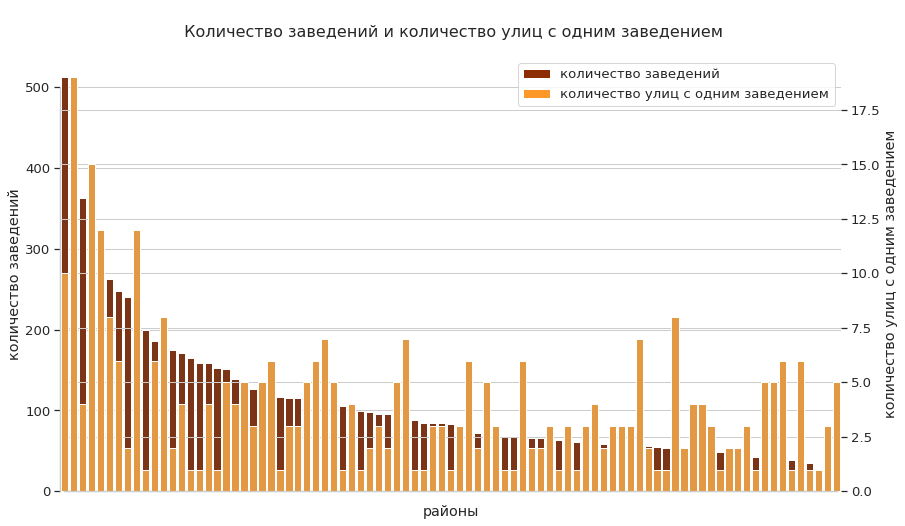

In [74]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x="area_name", y='total_objects', data=top_objects_areas,  color="#8c2d04", ax=ax)
ax.set(ylabel='количество заведений', xlabel='районы')
ax2 = ax.twinx() 
ax = sns.barplot(x="area_name", y='one_object_streets', data=top_objects_areas, color="#fe9929", ax=ax2)
ax.set_title('\n Количество заведений и количество улиц с одним заведением', fontsize=16, pad=20)
ax2.set(ylabel='количество улиц с одним заведением', xlabel='районы')
ax.set(xticklabels=[])
legend_elements = [Patch(facecolor='#8c2d04', label='количество заведений'),
                   Patch(facecolor='#fe9929', label='количество улиц с одним заведением')]
ax2.legend( handles=legend_elements)
sns.despine(trim=True);

Количество улиц с одним заведением не зависит от общего количества заведений в районе. 

In [75]:
cafe_areas = df[(df['area_name'] != 'no info')
                & (df['object_type'] == 'кафе')].groupby(
                    'area_name')['id'].count().reset_index()
cafe_areas.columns = ['area_name', 'cafe_cnt']
top_objects_areas = top_objects_areas.merge(cafe_areas, on='area_name')


In [76]:
bar_areas = df[(df['area_name'] != 'no info')
                & (df['object_type'] == 'бар')].groupby(
                    'area_name')['id'].count().reset_index()
bar_areas.columns = ['area_name', 'bar_cnt']
top_objects_areas = top_objects_areas.merge(bar_areas, on='area_name')


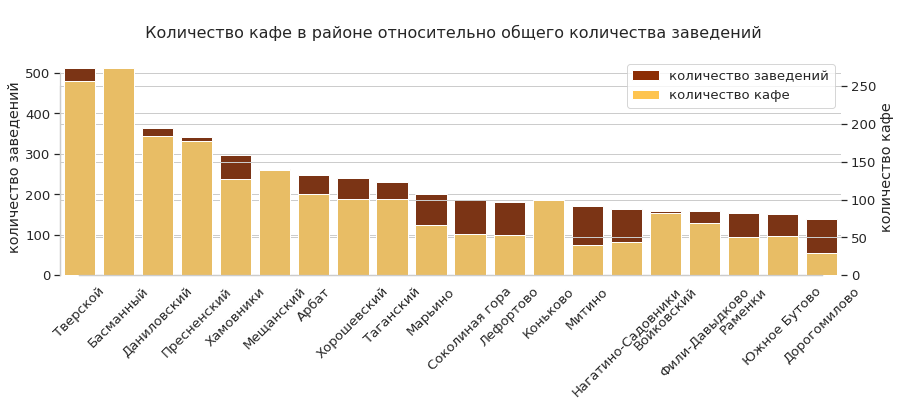

In [77]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(x="area_name", y='total_objects', data=top_objects_areas.head(20),  color="#8c2d04", ax=ax)
ax.set(ylabel='количество заведений', xlabel='')
ax2 = ax.twinx() 
sns.barplot(x="area_name", y='cafe_cnt', data=top_objects_areas.head(20), color="#fec44f", ax=ax2)
ax.set_title('\n Количество кафе в районе относительно общего количества заведений', fontsize=16, pad=20)
ax2.set(ylabel='количество кафе', xlabel='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
legend_elements = [Patch(facecolor='#8c2d04', label='количество заведений'),
                   Patch(facecolor='#fec44f', label='количество кафе')]
ax2.legend( handles=legend_elements)
sns.despine(trim=True);

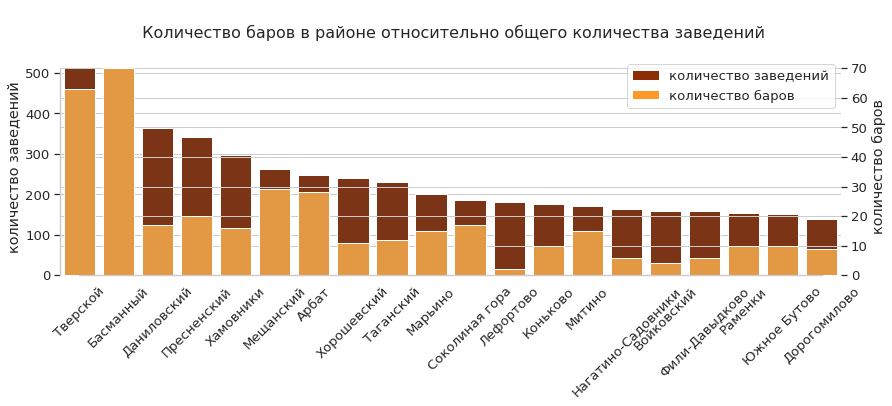

In [78]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(x="area_name", y='total_objects', data=top_objects_areas.head(20),  color="#8c2d04", ax=ax)
ax.set(ylabel='количество заведений', xlabel='')
ax2 = ax.twinx() 
sns.barplot(x="area_name", y='bar_cnt', data=top_objects_areas.head(20), color="#fe9929", ax=ax2)
ax.set_title('\n Количество баров в районе относительно общего количества заведений', fontsize=16, pad=20)
ax2.set(ylabel='количество баров', xlabel='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
legend_elements = [Patch(facecolor='#8c2d04', label='количество заведений'),
                   Patch(facecolor='#fe9929', label='количество баров')]
ax2.legend( handles=legend_elements)
sns.despine(trim=True);

Кафе распространены равномерно относительно других типов, а вот баров в некоторых районах есть недостаток. Наличие других типов заведений свидетельствует, о том что потенциальные клиенты там есть.

Данный метод очень условный, потому что "кафе" – тип собирательный и может функционировать как бар.

### Количество посадочных мест на улицах с большим количеством объектов общественного питания.

Построим диаграммы размаха для топовых улиц.

In [79]:
top_streets = list(top_streets['street'])

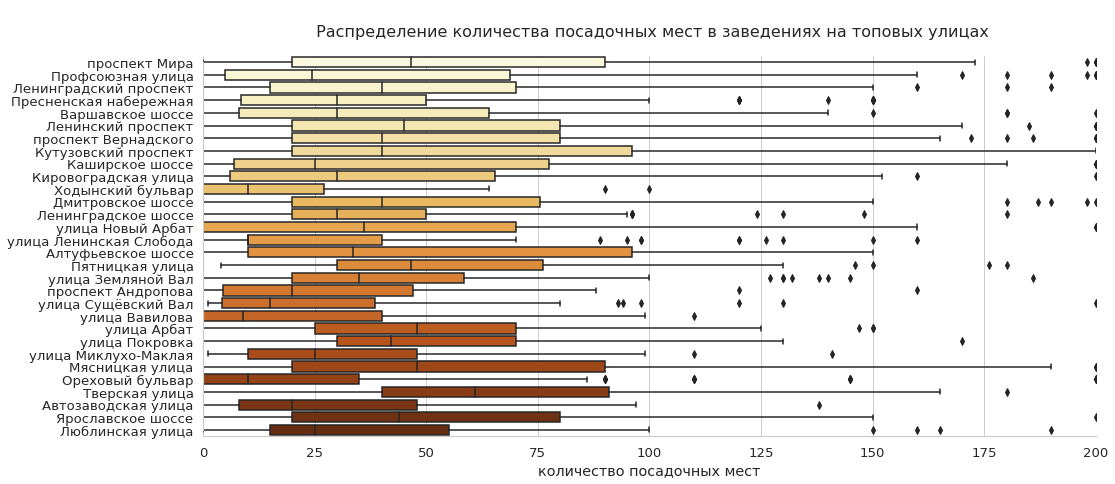

In [80]:
fig, ax = plt.subplots(figsize=(16, 7))
ax = sns.boxplot(x="number", y='street', data=df.query('street in @top_streets'),palette="YlOrBr", order=top_streets)
ax.set(Xlim=(0, 200))
ax.set_title('\n Распределение количества посадочных мест в заведениях на топовых улицах', fontsize=16, pad=20)
ax.set(ylabel='', xlabel='количество посадочных мест')
sns.despine(trim=True);

Улицы отсортированы в порядке количества заведений на них. Зависимость в  распределениях количества посадочных мест от количества заведений на улице не наблюдается. Посмотрим зависит ли среднее количество посадочных мест от количества других заведений на улице. Построим диаграмму рассеяния.

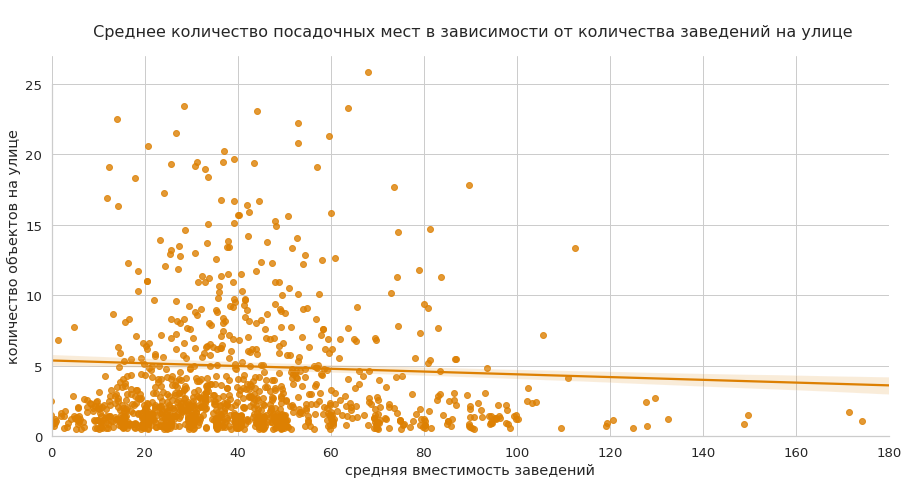

In [81]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.regplot(data=df.query('object_type == "кафе"').groupby('street').agg({'id': 'count', 'number': 'mean'}).reset_index(),
                 x='number',y='id', ci=68, y_jitter=0.5, x_jitter=0.8, truncate=True, color='#DD8002')
ax.set(xlim=(0, 180), ylim=(0, 27))
ax.set_title('\n Среднее количество посадочных мест в зависимости от количества заведений на улице', fontsize=16, pad=20)
ax.set(ylabel='количество объектов на улице', xlabel='средняя вместимость заведений')
sns.despine(trim=True);

Чем больше вокруг заведений, тем меньше посадочных мест. И наоборот если вокруг нет конкурентов то чем больше мест тем больше прибыль. Но возможно, что эта небольшая зависимость мнимая и является следствием того, что разные типы заведений имеют разную вместимость по разному распологаются. Посмотрим Как от насыщенности улицы заведениями зависит вместимость разных типов заведений. 

In [82]:
# посчитаем сколько заведений на каждой улице
streets_cnt_number_mean = df.query('street != "нет данных"').groupby('street').agg({'id': 'count', 'number': 'mean'}).reset_index()
streets_cnt_number_mean.columns = ['street', 'saturation', 'number_mean']


In [83]:
# создадим в основной таблице столбец показывающий насыщенность заведениями
df = df.merge(streets_cnt_number_mean[['street','saturation']], on='street')

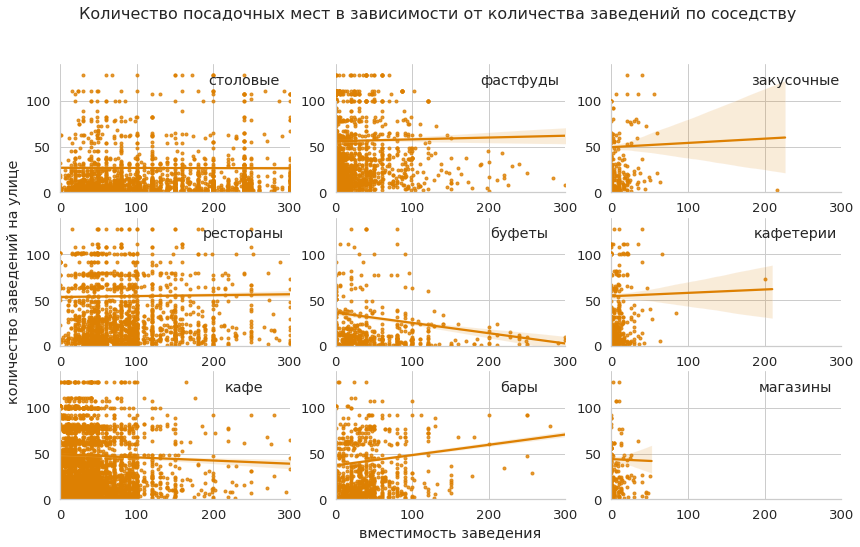

In [84]:
# построим графики
fig, axes = plt.subplots(3, 3, figsize=(14, 8))
data=df.query('street != "нет данных"')

sns.regplot(data=data.query('object_type == "столовая" '), marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[0, 0])
axes[0, 0].set_title('столовые',  pad=-20, x=0.8)
axes[0, 0].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')
sns.regplot(data=data.query('object_type == "фастфуд" '), marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[0, 1])
axes[0, 1].set_title('фастфуды',  pad=-20, x=0.8)
axes[0, 1].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')
sns.regplot(data=data.query('object_type == "кафе" '), marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[2, 0])
axes[2, 0].set_title('кафе',  pad=-20, x=0.8)
axes[2, 0].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')

sns.regplot(data=data.query('object_type == "ресторан" '), marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[1, 0])
axes[1, 0].set_title('рестораны', pad=-20, x=0.8)
axes[1, 0].set(xlim=(0, 300), ylim=(0, 140), ylabel='количество заведений на улице', xlabel='')
sns.regplot(data=data.query('object_type == "буфет" '),marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[1, 1])
axes[1, 1].set_title('буфеты', pad=-20, x=0.8)
axes[1, 1].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')
sns.regplot(data=data.query('object_type == "бар" '),marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[2, 1])
axes[2, 1].set_title('бары', pad=-20, x=0.8)
axes[2, 1].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='вместимость заведения')

sns.regplot(data=data.query('object_type == "закусочная" '),marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[0, 2])
axes[0, 2].set_title('закусочные', pad=-20, x=0.8)
axes[0, 2].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')
sns.regplot(data=data.query('object_type == "кафетерий" '),marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[1, 2])
axes[1, 2].set_title('кафетерии', pad=-20, x=0.8)
axes[1, 2].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')
sns.regplot(data=data.query('object_type == "магазин" '), marker='.',
                 x='number',  y='saturation', ci=68, truncate=False, color='#DD8002',ax=axes[2, 2])
axes[2, 2].set_title('магазины', pad=-20, x=0.8)
axes[2, 2].set(xlim=(0, 300), ylim=(0, 140), ylabel='', xlabel='')

fig.suptitle('Количество посадочных мест в зависимости от количества заведений по соседству', fontsize=16)
sns.despine(trim=True);


Вместимость почти всех видов не связана с наличием по соседству других заведений. Только кафе и буфеты демонстрируют обратную зависимость: чем меньше конкурентов тем больше посадочных мест. У кафе она выражена слабо у буфетов очень сильно. Возможно из за того, что буфеты в учреждениях (школах или институтах) заменяют по функции столовые. 
Интересно, что быры показывают прямую зависимость: чем больше вокруг заведений общепита тем больше в баре посадочных мест. Если допустить что количество мест в заведении связано со спросом, то новый бар нужно открывать там, где есть много других заведений общепита и нет других баров. 
Надо помнить, данная зависимость условна так как основывается на данных о количестве заведений на улице, которая может быть достаточно протяженной. И не учитывает возможного соседства если заведение расположено на соседней улице - за углом.

## Вывод 

Самым распространенным видом заведения является "кафе" ㅡ небольшое заведение на 30-40 посадочных мест с кухней. Среди кафе есть, как в прямом смысле кофейни, так и маленькие рестораны и бары. По этому их так много 38 % от общего количества заведений. Выбор между типами "ресторан" и "кафе" лежит в сфере маркетинга, по сути они очень похожи. 

Несмотря на то, что в среднем два заведения уже считаются сетью, что бы строить полноценную сеть нужно иметь легкомасштабируемую технологию. Для широких сетей лучше подходят фастфуды и кофейни с их стандартными технологиями и бизнеспроцессами.

У каждого типа заведения есть характерная вместимость, для кафе например это 40 мест.  От этой цифры следует отталкиваться, но окончательно определяться по месту. 
Одним из факторов при этом может быть наличие других заведений вокруг. Чем меньше вокруг конкурентов, тем на большее число посетителей можно рассчитывать.

Рекомендовать район расположения на основе этих данных сложно. Залог удачного расположения, кафе это наличие пешеходного трафика. Можно предположить, что в районах где уже много заведений этот трафик есть и рассматривать нужно в первую очередь их. Так же можно смотреть насыщен ли данный район конкретным типом заведений, есть ли в них потребность. 


Презентация: https://drive.google.com/file/d/1rMVkXf-6UoLXwFwbjUywxjIZUX4xhxBo/view?usp=sharing